# Strategizing grocery shopping

In shopping for groceries, an individual would usually create a list of items that need to be bought based on the stock level of household items and goods. However, doing the grocery in itself is a tedious job, and so a buyer would need to strategize what to buy first and what items can be grabbed together (as similar items are placed next to each other).

In an organization setting, procurement or the process of buying does not really differ much, except that the grocery list expands from a thousand to a million items that need to be bought everyday. Procurement is also not limited to buying goods, but also to setting contracts on service/s to be rendered. With procurement becoming large scale, below is a simplified decision on items that needs to be bought:

    1. Withdraw from inventory if item is still available;
    2. If there is a binding contract, immediately proceed with the purchase; and
    3. Strategize on bundling opportunities
    
With procurement magnified, efficiency issues also increases. Goods and/or services are bought on a daily basis, in a repetitive manner especially when similar items appear on different requests. Buyers are also pressured to immediately buy, while also negotiating with suppliers to lower down procurement costs.

Thus, the aim of this project is to automate procurement decisions that would otherwise be very tedious. This would help in increasing cost savings, and in the efficiency of the overall procurement process. 

# Summary of Results
-to be updated-

# Exploring Existing Data
There are three main data sources that are readily available or has a defined data architecture in the company database

    1. Historical spend data of 6 years;
    2. Dynamic outstanding purchase requests; and
    3. Inventory stock level
    
With these data sources, setup on organization procurement process (what teams handle what items), and average volume of requests would readily be known.

In [1]:
#Connect to organization team drive and sync to uploaded database file
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
db_path = "/gdrive/Team Drives/Performance Analytics/data_processed/sap_20190603.db" #change date to get latest update

import pandas as pd
import sqlalchemy as sqla

eng = sqla.create_engine("sqlite:///" + db_path)

with eng.begin() as con:
  df_purch = pd.read_sql_query("select * from sap_purchase_items", con)
  
#Connect to organization team drive and sync to uploaded spend data
drive.mount('/gdrive', force_remount=True)
csv_path = "/gdrive/Team Drives/Performance Analytics/report_library/spend_cube_files/2013-20190531 Awarded PO + Contract Data Finaledits v36.csv"
df_spend = pd.read_csv(csv_path, encoding='latin1')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
Mounted at /gdrive


/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,20,23,34,41,44,46,47,48,52,61,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1. Spend Data Quality - shown below is a snippet of the spend data. The cleaned data contains all the processed purchase request (also called purchase orders) from 2013 - May 2019 with additional calculated fields mainly:

    a. Material Hierarchies - based on the material group or the UNSPSC codes;
    
    b. Spend Type - whether operational, capital or inventory related application expense;
    
    c. Spend in PHP - other currencies were converted to peso as well
      

In [2]:
df_spend.head()

,Purchasing Document,Item,Document Date,Name of Vendor,Material,Material Group,Short Text,Cleaned Short Text,Order Quantity,Order Unit,Order Unit - Full,Net price,Net Order Value,Order Price Unit,Currency,Plant,Purchasing Group,Outline Agreement,Purchasing Doc. Type,Unique Code,CODE,Vendor Name,Cleaned Vendor Name,Vendor Type,Country,PO Amount in PHP,Buyer Name,BU Processor,Plant Intended,Cleaned Plant Intended,BU Intended,Document Type,Goods / Services,Charged To,Month,Year,Segment,Family,Class,Contract No.2,BCG Level 0,Per,Q Year,M Year,OEM vs NON OEM Tag (Place holder),Vendor Telephone,Origin country (Logistics),PR #,PR line item,PR Approve Date,Contract start date2,Contract end date2,Contract amount,Contract currency (Local currency),Contract type2,Contract execution date2,Buyer,GROUP,Proponent,Contractor's Name2,Title of Contract3,Remarks,Contract amount (PHP),Column1
0,305417,10,05/17/2013,200059 INTEGRAL INDUSTRIAL MANA,1812.0,31251502,"ACTUATOR; HYDRAULIC, FOR 20"" BUTTERFLY V","Actuator; Hydraulic, For 20"" Butterfly V",1.0,ASY,Asembly,54880.50,54880.50,ASY,USD,100H,H10,NaN,MB,305417_10,200059,INTEGRAL INDUSTRIAL MANA,INTEGRAL INDUSTRIAL MANAGEMENT CORP.,Mechanical Supplies,PH,2731347.61,HAW Alcantara,HO,LGBU UPPER MAHIAO POWER WREHSE,Leyte Geothermal Business Unit Upper Mahiao Po...,LGBU,Migration PO,GOODS,OPEX,May,2013,Manufacturing Components and Supplies,Pneumatic and hydraulic and electric control s...,Actuators,,FCRS,1,Q2 2013,M5 2013,OEM,(02)3554744,NaN,7e+09,10,,,,,,,,,,,,,,,NaN
1,305417,20,05/17/2013,200059 INTEGRAL INDUSTRIAL MANA,1813.0,31251502,"ACTUATOR; HYDRAULIC, FOR 8"" BUTTERFLY VA","Actuator; Hydraulic, For 8"" Butterfly Va",1.0,ASY,Asembly,43445.86,43445.86,ASY,USD,100H,H10,NaN,MB,305417_20,200059,INTEGRAL INDUSTRIAL MANA,INTEGRAL INDUSTRIAL MANAGEMENT CORP.,Mechanical Supplies,PH,2162257.01,HAW Alcantara,HO,LGBU UPPER MAHIAO POWER WREHSE,Leyte Geothermal Business Unit Upper Mahiao Po...,LGBU,Migration PO,GOODS,OPEX,May,2013,Connections and adhesives,Pneumatic and hydraulic and electric control s...,Actuators,,FCRS,1,Q2 2013,M5 2013,OEM,(02)3554744,NaN,7e+09,20,01/18/2013,,,,,,,,,,,,,,NaN
2,411304261,10,06/13/2013,300019 INDUSTRIAL CONTROLS SYST,55335.0,31251505,KIT;RESOLVER DRIVE & PCB;IQ70F25A;ROTORK,Kit;Resolver Drive & Pcb;Iq70F25A;Rotork,2.0,SET,Set,71312.50,142625.00,SET,PHP,100D,LG4,NaN,MB,411304261_10,300019,INDUSTRIAL CONTROLS SYST,INDUSTRIAL CONTROLS SYSTEMS INCORPORATED,Mechanical Supplies,PH,142625.00,RB Enero,LGBU,LGBU CENTRAL WAREHOUSE,Leyte Geothermal Business Unit Central Warehouse,LGBU,Migration PO,GOODS,OPEX,Jun,2013,Connections and adhesives,Pneumatic and hydraulic and electric control s...,Actuators,,Power Plant,1,Q2 2013,M6 2013,OEM,(02)4287456,NaN,0,NaN,,,,,,,,,,,,,,,NaN
3,305708,30,06/18/2013,300144 TOSHIBA CORPORATION,56368.0,31251505,KIT;REPAIR;TOSHIBA MSV ACTUATOR,Kit;Repair;Toshiba Msv Actuator,1.0,SET,Set,3320.00,3320.00,SET,USD,100G,H11,NaN,MB,305708_30,300144,TOSHIBA CORPORATION,TOSHIBA CORPORATION,Power Plant Professional Services,JP,165233.08,RR Bongco,HO,LGBU MAHANAGDONG POWER WAREHSE,Leyte Geothermal Business Unit Mahanagdong Pow...,LGBU,Migration PO,GOODS,OPEX,Jun,2013,Connections and adhesives,Pneumatic and hydraulic and electric control s...,Actuators,,Power Plant,1,Q2 2013,M6 2013,NON OEM,81334573787,NaN,0,NaN,,,,,,,,,,,,,,,NaN
4,305708,40,06/18/2013,300144 TOSHIBA CORPORATION,56369.0,31251505,"KIT;REPAIR;36"" CONTROL VALVE ACTUATOR;","Kit;Repair;36"" Control Valve Actuator;",1.0,SET,Set,63980.00,63980.00,SET,USD,100G,H11,NaN,MB,305708_40,300144,TOSHIBA CORPORATION,TOSHIBA CORPORATION,Power Plant Professional Services,JP,3184220.62,RR Bongco,HO,LGBU MAHANAGDONG POWER WAREHSE,Leyte Geothermal Business Unit Mahanagdong Pow...,LGBU,Migration PO,GOODS,OPEX,Jun,2013,Connections and adhesives,Pneumatic and hydraulic and electric control s...,Actuators,,Power Plant,1,Q2 2013,M6 2013,NON OEM,81334573787,NaN,0,NaN,,,,,,,,,,,,,,,NaN


2. Procurement Data Quality - as the data is loaded in the database, merging of data sources, cleaning and additional features were already added. Some notable additional features would include:

  a. Category assignment - refers to group a buyer is assigned to
  
  b. Bins of days outstanding
  
  c. Goods or services

#Part I: Outstanding Purchase Requisitions:
Shown below is a daily count of all purchase requests that are still outstanding. To be fair, daily average would be at around 3000 line items. The algorithm later on would then work on these outstanding purchases.

In [3]:
df_out_purch = df_purch.loc[(df_purch['id_pr_item'].notnull()) & (df_purch['status_yesno_pr_outstanding'] == 1), ['dim_po_material_shorttext','id_pr_item', 'dim_buyer_name', 'sla_po_release_target_date', 'dim_storage_loc', 'dim_category', 'time_pr_created', 'dim_bins_age_pr_outstanding', 'dim_goods_services']]
print(str(len(df_out_purch)) + ' purchase requisitions are still outstanding on June 3, 2019')

2934 purchase requisitions are still outstanding on June 3, 2019


As seen below, a large percentage of PRs remain to be outstanding for more than 90 days, mainly because processing a PR takes a lot of time due to negotiation, refinement of specs, and contracting. The disparity in aging of PRs implies that buyers prioritize more significant outstanding purchases, based on the delivery date.


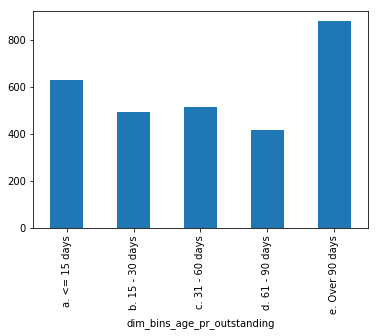

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
df_out_purch.groupby('dim_bins_age_pr_outstanding')['dim_bins_age_pr_outstanding'].count().plot.bar()

When a purchase request is initiated, the request is routed into the ERP system. A point supply chain person would then assign the request to a category, based on the application of the item. Shown below is a distribution of the outstanding requests.

There are five main categories namely power plant, indirect, civil works and FCRS, Drilling, and Site Fulfillment. As seen below, there are outstanding purchases that are assigned to H00 and "DO NOT USE" - these are staging assignments while an outstanding PR does not have a defined category yet. This is because the assignment is manually done.

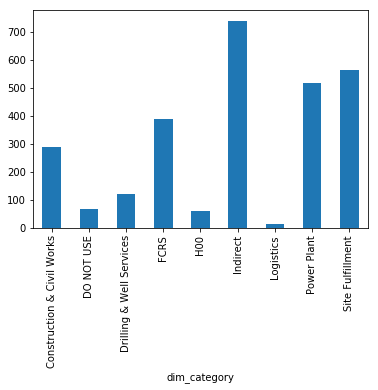

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
df_out_purch.groupby('dim_category')['dim_category'].count().plot.bar()

With this, the first recommendation that could be automated is the **assigned category**. Automating this portion would allow the routing of purchase requests to be more efficient, especially to those categories with high influx volume of requests, specifically indirect category.

Before a purchase is done however, the **requested item should still be checked with the current inventory to**:
1. Prevent bloating of inventory which would result in increased holding costs; and
2. Frees up more time for buyers to focus on other requests, thereby increasing efficiency of the procurement process. 

This is also done manually by a dedicated inventory analyst.

#Part II: Purchase Price Variances
This section aims to explore variances of purchase prices from different vendors. Shown below are the top items which are most frequently bought - to see if there are significant differences when buying from different vendors

In [6]:
df_spend2 = df_spend.loc[(df_spend['Year'] >= 2018) & (df_spend['PO Amount in PHP'] > 1) & (df_spend['Material'] > 0) & (df_spend['Order Unit'] != 'LOT') & (df_spend['Goods / Services'] != 'SERVICES')]

#df_spend2['PO Amount in PHP'] = df_spend2['PO Amount in PHP'].str.replace(",", "")
#df_spend2['PO Amount in PHP'] = df_spend2['PO Amount in PHP'].str.strip()
#df_spend2['PO Amount in PHP'] = df_spend2['PO Amount in PHP'].str.replace("-", "0")

#df_spend2['Order Quantity'] = df_spend2['Order Quantity'].str.replace(",", "")
#df_spend2['Order Quantity'] = df_spend2['Order Quantity'].str.strip()
#df_spend2['Order Quantity'] = df_spend2['Order Quantity'].str.replace("-", "0")

df_spend2['Unit Price in PHP'] = pd.to_numeric(df_spend2['PO Amount in PHP']) / pd.to_numeric(df_spend2['Order Quantity'])
df_purch_price = df_spend2.groupby(['Cleaned Short Text']).agg({'Unit Price in PHP': ['mean', 'median', 'max', 'min', 'count']}).reset_index()
df_purch_price = df_purch_price.sort_values(('Unit Price in PHP','count'), ascending = False)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


As shown below - for a single item, it could have a wide range of unit price even considering that only purchases made within the year are included: e.g safety footwear has a max unit price of PHP17k, and min price of PHP303.

In [7]:
top10 = df_purch_price.head(20)
top10

Cleaned Short Text  ... Unit Price in PHP
                                                ...             count
1590           Drugs & Pharmaceutical Products  ...               691
4974               Tools And General Machinery  ...               600
4661  Structure/Bldg/Construction/Manufactcomp  ...               570
2803          Laboratory Supplies And Fixtures  ...               486
4237                            Safety Apparel  ...               412
2095                              Fuel;Diesel;  ...               356
2094                               Fuel;Diesel  ...               342
2978            Medical Eqpt & Accs & Supplies  ...               341
2099                   Furniture & Furnishings  ...               275
3845      Printer & Fax & Photocopier Supplies  ...               255
4238                           Safety Footwear  ...               241
3838                Prepared & Preserved Foods  ...               230
1161          Cleaning And Janitorial Supplies  ...               225
1476                             Desk Supplies  ...               220
5600                       Writing Instruments  ...               219
1722   Electrical Eqpt And Components And Supp  ...               211
83      Apparel & Luggage & Personal Care Prod  ...               202
1214          Computer Equipment & Accessories  ...               178
3849                Printing And Writing Paper  ...               161
1721       Electrical Controls And Accessories  ...               150

[20 rows x 6 columns]

In [0]:
df_purch_price_spec = df_spend2.loc[df_spend2['Cleaned Short Text'] == 'Safety Footwear']
df_purch_price_spec_analysis = df_purch_price_spec.groupby(['Cleaned Short Text', 'Cleaned Vendor Name']).agg({'Unit Price in PHP': ['mean', 'median', 'max', 'min', 'count']}).reset_index()

Upon looking at the specific suppliers providing the same safety footwear, there is a large disparity depending on the vendor. This may be because of the material - but assuming that the item would serve the same purpose, usage and product life - there may be a need to identify the cheapest vendor.

In [9]:
df_purch_price_spec_analysis

Cleaned Short Text  ... Unit Price in PHP
                       ...             count
0     Safety Footwear  ...                 3
1     Safety Footwear  ...               102
2     Safety Footwear  ...                 6
3     Safety Footwear  ...                11
4     Safety Footwear  ...                63
5     Safety Footwear  ...                 2
6     Safety Footwear  ...                 1
7     Safety Footwear  ...                24
8     Safety Footwear  ...                 3
9     Safety Footwear  ...                24
10    Safety Footwear  ...                 2

[11 rows x 7 columns]

In [0]:
df_purch_price_spec = df_spend2.loc[df_spend2['Cleaned Short Text'] == 'Safety Footwear']
df_purch_price_spec_analysis2 = df_purch_price_spec.groupby(['Cleaned Short Text', 'Plant']).agg({'Unit Price in PHP': ['mean', 'median', 'max', 'min', 'count']}).reset_index()

Plant, also shows the same disparity pattern. This is because purchases before are decentralized, and so buying units from different plants have different strategies

In [11]:
df_purch_price_spec_analysis2

Cleaned Short Text Plant Unit Price in PHP  ...                         
                                         mean  ...       max      min count
0     Safety Footwear  1003       6696.430000  ...   6696.43  6696.43     1
1     Safety Footwear  100A       4613.096667  ...   6696.43  3571.43     3
2     Safety Footwear  100D       7745.865556  ...   9900.00   423.50     9
3     Safety Footwear  100J       2309.325556  ...   8839.29   616.07    45
4     Safety Footwear  310B       2832.590000  ...   3571.43   616.07    20
5     Safety Footwear  320A       3571.430000  ...   3571.43  3571.43     2
6     Safety Footwear  B001       2093.750000  ...   3571.43   616.07     4
7     Safety Footwear  E001       2976.885556  ...  10350.00   303.00    27
8     Safety Footwear  E002       3960.500000  ...   7065.00   616.07    10
9     Safety Footwear  E003       2309.678966  ...   9900.00   380.00    29
10    Safety Footwear  E004       6791.795714  ...  17857.14   570.00     7
11    Safety Footwear  E005       2339.162857  ...   4800.00   468.00    56
12    Safety Footwear  E006       3340.035556  ...  10044.00   468.00     9
13    Safety Footwear  G001       2118.407500  ...   5500.00   380.00     4
14    Safety Footwear  G002       2083.264000  ...   3571.43   468.00    15

[15 rows x 7 columns]

#Part _: Suggestion Feature for Categories

When a purchase request is created, it is routed to different buying groups depending on the item itself. For example, all tissues, office supplies and items not used in production are assigned to Indirect Group. However, the buying group assignment is very manual. The aim of this section is to create a model on predicting the buying group to be assigned based on the item descriptions that are in the purchase request.

In [0]:
df_spend_test = df_spend[['BCG Level 0', 'Cleaned Short Text']]

Shown below is a sample of the text descriptions, and the assigned category. This is historical spend data that has a span of about 6 years.

In [13]:
df_spend_test.head()

,BCG Level 0,Cleaned Short Text
0,FCRS,"Actuator; Hydraulic, For 20"" Butterfly V"
1,FCRS,"Actuator; Hydraulic, For 8"" Butterfly Va"
2,Power Plant,Kit;Resolver Drive & Pcb;Iq70F25A;Rotork
3,Power Plant,Kit;Repair;Toshiba Msv Actuator
4,Power Plant,"Kit;Repair;36"" Control Valve Actuator;"


Below shows the model itself - it makes use of multinomial naive bayes that is usually used in text classification problems.

In [14]:
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer

#count_vect = CountVectorizer()
#x_train_counts = count_vect.fit_transform(df_spend_test['Cleaned Short Text'].values.astype('U'))
#tfidf_transformer = TfidfTransformer()
#x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

train_x, test_x, train_y, test_y = train_test_split(df_spend_test['Cleaned Short Text'], df_spend_test['BCG Level 0'], test_size=0.3)
text_test_x = test_x,
count_vect = CountVectorizer()
tfidf_transformer = TfidfTransformer()

def transform_text(column_x):
  transformed_x = tfidf_transformer.fit_transform(count_vect.fit_transform(column_x.values.astype('U')))
  return transformed_x

def transform_text2(column_x): #since vectorizer and transformer has been fitted already
  transformed_x = tfidf_transformer.transform(count_vect.transform(column_x.values.astype('U')))
  return transformed_x

train_x = transform_text(train_x)
test_x = transform_text2(test_x)

clf = MultinomialNB().fit(train_x, train_y)
y_score = clf.predict(test_x)

pred_y = clf.predict(test_x)

results = pd.DataFrame({'Material Description': test_x, 'Actual': test_y, 'Predicted': pred_y.flatten()})  
results.head()
#text_test_x[0][0]

,Actual,Material Description,Predicted
138414,FCRS,"(0, 18069)\t0.6286353183165281\n (0, 9122)\...",FCRS
36511,Indirect,"(0, 18069)\t0.6286353183165281\n (0, 9122)\...",Indirect
127151,Indirect,"(0, 18069)\t0.6286353183165281\n (0, 9122)\...",Indirect
202961,Indirect,"(0, 18069)\t0.6286353183165281\n (0, 9122)\...",Indirect
220332,Indirect,"(0, 18069)\t0.6286353183165281\n (0, 9122)\...",Indirect


Shown below are the coefficient of determinations that are computed for the train set, and the test set.

In [15]:
print(clf.score(train_x, train_y))
print(clf.score(test_x, test_y))

0.8649925442204854
0.8538392321535693


Below extends the implementation of the model to the outstanding purchase requisitions

In [0]:
y = clf.predict(transform_text2(df_out_purch['dim_po_material_shorttext']))

In [0]:
outstanding_purch_predicted = pd.DataFrame({'PR Number': df_out_purch['id_pr_item'], 'Material Description': df_out_purch['dim_po_material_shorttext'], 'Predicted Category': y})  

Below shows the predicted category assignment for each of the material description

In [18]:
outstanding_purch_predicted

,Material Description,PR Number,Predicted Category
0,"VALVE;GLOBE;SS;1/2"";ASME B16.34, 300#;",1000048443_00010,FCRS
1,"CORE;RADIATOR;38.5""X38.5""X5"";8ROWS",1000049895_00010,Indirect
2,"PACKING;GARLOCK;SIZE: 1/4""",1000050410_00010,Indirect
3,VALVE;SOLENOID;E321F32,1000050620_00010,FCRS
4,PACKING;STEM;NON-ASBESTOS;SQUARE BRAIDED,1000050728_00010,FCRS
5,"TEE;EQUAL;SS316;1/2""FNPTx3000#",1000050850_00010,FCRS
6,GLASS;SIGHT,1000050862_00010,Indirect
7,WASHER;CLAW;M30;STAINLESS;FUJI,1000052298_00010,Power Plant
8,BREAKER;CIRCUIT;POWER;LTB245E1;1P;BLK222,1000053301_00010,Power Plant
9,"GAUGE;PRESSURE;ASHCROFT;3"";316SS;0-10BAR",1000054120_00010,FCRS
